In [1]:
import os 
import sys
from tqdm import tqdm
import importlib
import numpy as np
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt

module_path = '/home/lun/project-basileus/seq-gan/'
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
if 'sgtlstm' in sys.modules:
    importlib.reload(sys.modules['sgtlstm'])

from sgtlstm.utils import create_dataset, recover_timedelta_to_timestamp
# from sgtlstm.SeqGan import build_G, build_D, build_critic
from sgtlstm.TimeLSTM import TimeLSTM0, TimeLSTM1, TimeLSTM2, TimeLSTM3
# from sgtlstm.train import generate_batch_sequence_by_rollout, train_discriminator, train_generator

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Input, LSTM, Embedding, Reshape, Dense, Dropout
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from tensorflow.keras import regularizers

from sgtlstm.TimeLSTM import TimeLSTM0, TimeLSTM1, TimeLSTM2, TimeLSTM3

tf.keras.backend.set_floatx('float64')


## Load data 

In [4]:
pos_data_path = '/home/lun/project-basileus/seq-gan/data/long_seqs_v10/positive_long_sequences.pickle'
neg_data_path_v10 = '/home/lun/project-basileus/seq-gan/data/long_seqs_v10/negative_long_sequences.pickle'

# neg_data_path_v9 = '/home/lun/project-basileus/seq-gan/data/long_seqs_v9/negative_long_sequences.pickle'

neg_data_path_v8 = '/home/lun/project-basileus/seq-gan/data/long_seqs_v8/negative_long_sequences.pickle'

def load_sequence_from_pickle_to_numpy(pickle_file_path):
    """
        A list of sequence in format of (event_type, time_delta)
    :param pickle_file_path: e.g. /.../project-basileus/seq-gan/data/fixed_length/valid_sequences.pickle
    :return: (event_type_seqs, time_delta)
    """
    with open(pickle_file_path, 'rb') as f:
        raw_seqs = pickle.load(f)

    if not raw_seqs or not raw_seqs[0]:
        return np.array([]), np.array([])

    N = len(raw_seqs)
    T = len(raw_seqs[0])
    
    seqs = np.array(raw_seqs)
#     print(seqs.shape)
    
    et_seqs = seqs[:, :, 0].astype(np.float64).reshape((N, T, 1))
    ts_seqs = seqs[:, :, 1].astype(np.float64).reshape((N, T, 1))
    return et_seqs, ts_seqs
    
# only use dense v9 for pos data
pos_event_type_seqs, pos_timestamp_seqs = load_sequence_from_pickle_to_numpy(pos_data_path)

# # use both dense v9 and sparse v8 for neg data
neg_event_type_seqs_v10, neg_timestamp_seqs_v10 = load_sequence_from_pickle_to_numpy(neg_data_path_v10)
neg_event_type_seqs_v8, neg_timestamp_seqs_v8 = load_sequence_from_pickle_to_numpy(neg_data_path_v8)

neg_event_type_seqs = np.concatenate([neg_event_type_seqs_v8, neg_event_type_seqs_v10], axis=0)
neg_timestamp_seqs = np.concatenate([neg_timestamp_seqs_v8, neg_timestamp_seqs_v10], axis=0)

# neg_event_type_seqs, neg_timestamp_seqs = load_sequence_from_pickle_to_numpy(neg_data_path)

In [5]:
pos_seqs_np = np.concatenate([pos_event_type_seqs, pos_timestamp_seqs], axis=2)
neg_seqs_np = np.concatenate([neg_event_type_seqs, neg_timestamp_seqs], axis=2)

## Global Variables 

In [6]:
BATCH_SIZE = 64
T = 20 + 1
VOCAB = ['END/PADDING', 'INIT', 'start', 'view', 'click', 'install']
EVENT_VOCAB_DIM = len(VOCAB)
EMB_DIM = 6
HIDDEN_DIM = 100

END_TOKEN = 0
MAX_TIME = 1024

## Load pretrained models

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Input, LSTM, Embedding, Reshape, Dense
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from tensorflow.keras import regularizers

from sgtlstm.TimeLSTM import TimeLSTM0, TimeLSTM1, TimeLSTM2, TimeLSTM3

tf.keras.backend.set_floatx('float64')

def build_D_2(T, event_vocab_dim, emb_dim, hidden_dim=11):
    """
        Build a discriminator for event type sequence of shape (batch_size, T, input_dim)
        and input event type sequence of shape (batch_size, T, 1)
    :param T: length of the sequence
    :param event_vocab_dim: size of event vocabulary ['na', 'init', 'start', 'view', 'click', 'install']
    :param emb_dim: dimension of the embedding layer output for event type
    :param hidden_dim: dimension hidden of the time lstm cell
    :return: discriminator D
    """
    # Time-LSTM:
    i_et = Input(shape=(T, 1), name='event_type')  # input of discrete feature event type
    i_ts = Input(shape=(T, 1), name='time_delta')  # input of continuous feature timestamp
    mask_layer = tf.keras.layers.Masking(mask_value=0., input_shape=(T, 1))
    masked_ts = mask_layer(i_ts)
    masked_et = mask_layer(i_et)

    embed0 = Embedding(input_dim=event_vocab_dim, output_dim=emb_dim, input_length=T, mask_zero=True)(masked_et)
    embed0 = Reshape((T, emb_dim))(embed0)  # shape=[Batch_size, T, emb_dim]
    merged0 = tf.keras.layers.concatenate([embed0, masked_ts], axis=2)  # # shape=[Batch_size, T, emb_dim + time_dim]

    hm, tm = TimeLSTM1(hidden_dim, activation='selu', name='time_lstm', return_sequences=False)(merged0)

    time_comb = tf.keras.layers.concatenate([hm, tm], axis=1)

    # predicted real prob
    real_prob = Dense(1, activation='sigmoid', name='fraud_prob', kernel_regularizer=regularizers.l1_l2(l1=1e-3, l2=1e-3))(
        time_comb)

    discriminator = Model(
        inputs=[i_et, i_ts],
        outputs=[real_prob])

    return discriminator

def build_G_2(batch_size, event_vocab_dim, emb_dim, hidden_dim=11):
    """
        Build a generator for event type sequence of shape (batch_size, T, input_dim)
        and input event type sequence of shape (batch_size, T, 1)
    :param batch_size: batch size must been specified at generator
    :param event_vocab_dim: size of event vocabulary ['na', 'start', 'click', 'install']
    :param emb_dim: dimension of the embedding layer output for event type
    :param hidden_dim: dimension hidden of the time lstm cell
    :return:
    """
    # Time-LSTM:
    i_et = Input(batch_shape=(batch_size, None, 1), name='event_type')  # input of discrete feature event type
    i_ts = Input(batch_shape=(batch_size, None, 1), name='time_delta')  # input of continuous feature timestamp

    mask_layer = tf.keras.layers.Masking(mask_value=0., input_shape=(None, 1))
    masked_et = mask_layer(i_et)
    masked_ts = mask_layer(i_ts)

    embed0 = Embedding(input_dim=event_vocab_dim, output_dim=emb_dim, mask_zero=True)(masked_et)
    embed0 = Reshape([1, emb_dim])(embed0)
    merged0 = tf.keras.layers.concatenate([embed0, masked_ts], axis=2)

    hm, tm = TimeLSTM1(hidden_dim, activation='selu', name='time_lstm',
                       stateful=True, return_sequences=False)(merged0)
    
    time_comb = tf.keras.layers.concatenate([hm, tm], axis=1)
    
    dense_time = Dense(hidden_dim // 2, activation='linear', name='dense_time')(time_comb)
    dense_token = Dropout(rate=0.4)(dense_time)
    time_out = Dense(1 + 1, activation='linear', name='output')(dense_token)
    time_out = tfp.layers.DistributionLambda(
        lambda t: tfd.Normal(loc=t[..., :1],
                             scale=1 + tf.math.softplus(t[..., 1:])),
        name='Normal')(time_out)

    # predicted prob of next token
    dense_token = Dense(hidden_dim // 2, activation='linear', name='dense_token')(time_comb)
    dense_token = Dropout(rate=0.4)(dense_token)
    token_prob = Dense(event_vocab_dim, activation='softmax', name='token_prob')(dense_token)
    generator = Model(
        inputs=[i_et, i_ts],
        outputs=[token_prob, time_out])
    return generator


In [8]:
def generate_batch_sequence_by_rollout(
        G, batch_size, T, end_token=0, init_token=1.0, max_time=1024, verbose=False):
    # Begin from dummy init state (init_token=1, init_timestamp=0.0)
    curr_state_et = tf.ones([batch_size, 1, 1], dtype=tf.float64)
    curr_state_ts = tf.zeros([batch_size, 1, 1], dtype=tf.float64)

    all_state_et = curr_state_et
    all_state_ts = curr_state_ts

    episode_token_probs = tf.constant(1., dtype=tf.float64, shape=(batch_size, 1))
    gaussian_log = tf.constant(0., dtype=tf.float64, shape=(batch_size, 1))

    G.reset_states()

    for step in range(1, T):  # sequence length
        token_prob, time_out = G([curr_state_et, curr_state_ts])

        sampled_et = tf.random.categorical(tf.math.log(token_prob), num_samples=1, dtype=tf.int32)
        sampled_et = tf.reshape(sampled_et, [batch_size, 1, 1])

        # get the chosen token probability per batch for each step
        batch_sample_et = tf.reshape(sampled_et, (batch_size, 1))
        batch_ind = tf.reshape(tf.range(0, batch_size), (batch_size, 1))
        batch_sample_et_2d = tf.concat([batch_ind, batch_sample_et], axis=1)

        sampled_token_prob = tf.reshape(tf.gather_nd(token_prob, batch_sample_et_2d), (batch_size, 1))
        episode_token_probs = tf.concat([episode_token_probs, sampled_token_prob], axis=1)

        # cast sampled_et into float
        sampled_et = tf.cast(sampled_et, dtype=tf.float64)

        # stop genererating once hit end_token
        cond_end_token = tf.equal(curr_state_et, end_token)
        curr_state_et = tf.where(cond_end_token, curr_state_et, sampled_et)
        all_state_et = tf.concat([all_state_et, curr_state_et], axis=1)

        # generate one timstamp using time_out
        sampled_ts_raw = time_out.sample()
        sampled_ts = tf.clip_by_value(tf.reshape(sampled_ts_raw, (batch_size, 1, 1))
                                      , clip_value_min=0, clip_value_max=max_time)

        # get the gaussian log likelihood for the sampled timestamps
        sampled_gaussian_log = time_out.log_prob(sampled_ts_raw)
        gaussian_log = tf.concat([gaussian_log, sampled_gaussian_log], axis=1)

        # stop generating once hit end_token
        curr_state_ts = tf.where(cond_end_token, curr_state_et, sampled_ts)
        all_state_ts = tf.concat([all_state_ts, curr_state_ts], axis=1)

    return all_state_et, all_state_ts, episode_token_probs, gaussian_log


def generate_sequences(N_gen, generator, batch_size, T, recover_to_timestamp=True):
    """
        Generate sequences batch per batch
    :param N_gen: total number of seqs to be generated
    :param generator:
    :param batch_size:
    :param T:
    :param recover_to_timestamp: whether to recover time deltas to absolute timestamps
    :return: a python list of shape [N_gen, T, 2]
    """
    all_type_seq = None
    all_time_seq = None
    N = 0

    while N < N_gen:
        batch_state_et, batch_state_ts, _, _ = generate_batch_sequence_by_rollout(generator, batch_size, T,
                                                                                  end_token=0, init_token=1.0,
                                                                                  max_time=1024, verbose=False)

        batch_type_seq = batch_state_et.numpy()
        batch_time_seq = batch_state_ts.numpy()

        # recover time delta to time stamps
        if recover_to_timestamp:
            batch_time_seq = np.cumsum(batch_time_seq, axis=1)

        if all_type_seq is None:
            all_type_seq = batch_type_seq
        else:
            all_type_seq = np.concatenate([all_type_seq, batch_type_seq], axis=0)

        if all_time_seq is None:
            all_time_seq = batch_time_seq
        else:
            all_time_seq = np.concatenate([all_time_seq, batch_time_seq], axis=0)

        N += batch_size

    # concat type and time in depth
    concated_seq_list = np.concatenate([all_type_seq, all_time_seq], axis=2).tolist()

    return concated_seq_list[:N_gen]


In [9]:
# discriminator = build_D_2(
#     T = T,
#     event_vocab_dim = EVENT_VOCAB_DIM,
#     emb_dim = EMB_DIM,
#     hidden_dim= HIDDEN_DIM,
# )

# discriminator.build(input_shape=((BATCH_SIZE, T, 1), (BATCH_SIZE, T, 1)))

# D_save_path = '/home/lun/project-basileus/seq-gan/experiment_results/long_seqs_v9/init_pretrained/pretrained_disc_weights/model.tf'
# discriminator.load_weights(D_save_path)

In [10]:
# generator = build_G_2(
#     batch_size=BATCH_SIZE,
#     event_vocab_dim = EVENT_VOCAB_DIM,
#     emb_dim = EMB_DIM,
#     hidden_dim= HIDDEN_DIM)

# generator.build(input_shape=((BATCH_SIZE, T, 1), (BATCH_SIZE, T, 1)))

# G_save_path = '/home/lun/project-basileus/seq-gan/experiment_results/long_seqs_v9/init_pretrained/pretrained_gen_weights/model_dropout.tf'
# generator.load_weights(G_save_path)

## G0: Initial generator G0

In [11]:
G0 = build_G_2(
    batch_size=BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM)

G0.build(input_shape=((BATCH_SIZE, T, 1), (BATCH_SIZE, T, 1)))

## G1: pretrained generator G1

In [12]:
G1 = build_G_2(
    batch_size=BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM)

G1.build(input_shape=((BATCH_SIZE, T, 1), (BATCH_SIZE, T, 1)))

G1_save_path = '/home/lun/project-basileus/seq-gan/experiment_results/long_seqs_v10/init_pretrained/pretrained_gen_weights/model_dropout.tf'
G1.load_weights(G1_save_path)

## G2: 100 steps eq Generator

In [13]:
G2 = build_G_2(
    batch_size=BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM)

G2.build(input_shape=((BATCH_SIZE, T, 1), (BATCH_SIZE, T, 1)))

G2_save_path = '/home/lun/project-basileus/seq-gan/experiment_results/long_seqs_v10/100_eq/gen_weights/gen_model.tf'
G2.load_weights(G2_save_path)

## G3: 100 steps eq Generator with Sparse pretraining

In [14]:
G3 = build_G_2(
    batch_size=BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM)

G3.build(input_shape=((BATCH_SIZE, T, 1), (BATCH_SIZE, T, 1)))

G3_save_path = '/home/lun/project-basileus/seq-gan/experiment_results/long_seqs_v10/100_eq_with_sparse/gen_weights/gen_model.tf'
G3.load_weights(G3_save_path)

## G4: D-Dmoninates

In [15]:
G4 = build_G_2(
    batch_size=BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM)

G4.build(input_shape=((BATCH_SIZE, T, 1), (BATCH_SIZE, T, 1)))

G4_save_path = '/home/lun/project-basileus/seq-gan/experiment_results/long_seqs_v10/D_dominates/gen_weights/gen_model.tf'
G4.load_weights(G4_save_path)

## G5: D-Dmoninates with sparse pretraining

In [16]:
G5 = build_G_2(
    batch_size=BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM)

G5.build(input_shape=((BATCH_SIZE, T, 1), (BATCH_SIZE, T, 1)))

G5_save_path = '/home/lun/project-basileus/seq-gan/experiment_results/long_seqs_v10/D_dominates_with_sparse/gen_weights/gen_model.tf'
G5.load_weights(G5_save_path)

## Sample from True data

In [17]:
N_sample = 10000
pos_sample_idx = np.random.choice(np.arange(0, pos_seqs_np.shape[0]), size=N_sample, replace=False)
neg_sample_idx = np.random.choice(np.arange(0, neg_seqs_np.shape[0]), size=N_sample, replace=False)

pos_seqs_sample = pos_seqs_np[pos_sample_idx,:,:].tolist()
neg_seqs_sample = neg_seqs_np[neg_sample_idx,:,:].tolist()

## Generate Seqs for  G0, G1, G2, G3

In [18]:
N_gen = 10000
g0_seqs = generate_sequences(N_gen, G0, batch_size=BATCH_SIZE, T=T, recover_to_timestamp=False)
g1_seqs = generate_sequences(N_gen, G1, batch_size=BATCH_SIZE, T=T, recover_to_timestamp=False)
g2_seqs = generate_sequences(N_gen, G2, batch_size=BATCH_SIZE, T=T, recover_to_timestamp=False)
g3_seqs = generate_sequences(N_gen, G3, batch_size=BATCH_SIZE, T=T, recover_to_timestamp=False)
g4_seqs = generate_sequences(N_gen, G4, batch_size=BATCH_SIZE, T=T, recover_to_timestamp=False)
g5_seqs = generate_sequences(N_gen, G5, batch_size=BATCH_SIZE, T=T, recover_to_timestamp=False)

In [19]:
g0_seqs[0]

[[1.0, 0.0],
 [5.0, 1.2573636384397846],
 [4.0, 0.0],
 [3.0, 0.0],
 [2.0, 0.42064731815885936],
 [3.0, 3.059393199781663],
 [4.0, 2.2680005703001345],
 [4.0, 0.0],
 [2.0, 0.4671216103260555],
 [3.0, 0.0],
 [0.0, 4.008671689872464],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0]]

In [20]:
g1_seqs[0]

[[1.0, 0.0],
 [4.0, 22.870753279598325],
 [4.0, 20.479828217814944],
 [3.0, 28.180846050120056],
 [5.0, 18.74720668933616],
 [2.0, 24.4519197624749],
 [2.0, 5.801111165518934],
 [2.0, 18.17581747744713],
 [5.0, 10.491224735050507],
 [3.0, 18.784980648895946],
 [5.0, 32.77103939542846],
 [3.0, 27.099016290821197],
 [4.0, 27.463480787218863],
 [2.0, 10.421644298048907],
 [4.0, 33.32352481661519],
 [4.0, 22.839978058380215],
 [3.0, 3.6569223275435014],
 [5.0, 28.426810453650482],
 [4.0, 23.056591326754358],
 [3.0, 12.940285673398652],
 [5.0, 26.53493185692754]]

In [21]:
g2_seqs[0]

[[1.0, 0.0],
 [2.0, 5.681360831926993],
 [3.0, 16.173979586531644],
 [5.0, 25.21233666580187],
 [2.0, 4.544603044475759],
 [3.0, 20.45783792222334],
 [4.0, 11.56737781248328],
 [2.0, 7.724331761295753],
 [4.0, 30.48807645297466],
 [4.0, 12.402829096802204],
 [2.0, 20.671639497812688],
 [3.0, 14.784665254530282],
 [3.0, 8.930275971739134],
 [2.0, 18.297427821303724],
 [4.0, 11.041388653453978],
 [2.0, 19.03060084348816],
 [2.0, 31.18739682220041],
 [3.0, 21.353363489028045],
 [4.0, 11.207781228692458],
 [3.0, 7.603555915803067],
 [5.0, 31.107550760580942]]

In [22]:
g3_seqs[0]

[[1.0, 0.0],
 [4.0, 4.417914375941309],
 [4.0, 23.04000550834422],
 [2.0, 22.740614575563953],
 [4.0, 17.549109798269473],
 [3.0, 22.668909275739622],
 [4.0, 23.043828796797627],
 [5.0, 16.153757064790046],
 [4.0, 20.148534324002306],
 [5.0, 22.200736217502705],
 [4.0, 23.004726480555515],
 [3.0, 23.207770012978198],
 [4.0, 22.09430839458178],
 [5.0, 24.99294039489868],
 [2.0, 22.957916352200076],
 [3.0, 23.057915894164367],
 [4.0, 22.021849316496787],
 [2.0, 24.922780736379522],
 [4.0, 25.603198521781316],
 [4.0, 25.759403726535712],
 [2.0, 28.329350854450603]]

In [23]:
g4_seqs[0]

[[1.0, 0.0],
 [2.0, 3.441707069060029],
 [4.0, 11.304648058488656],
 [3.0, 10.315916317518585],
 [4.0, 6.301349077316291],
 [2.0, 5.741975412094728],
 [4.0, 2.7349961630305133],
 [2.0, 0.0],
 [4.0, 2.7784576294046848],
 [4.0, 0.0],
 [4.0, 0.0],
 [2.0, 0.0],
 [2.0, 1.924143026815765],
 [5.0, 0.0],
 [2.0, 3.7396510728895884],
 [5.0, 0.0],
 [2.0, 9.689681101197888],
 [2.0, 0.0],
 [2.0, 0.0],
 [2.0, 0.0],
 [2.0, 0.0]]

In [24]:
g5_seqs[0]

[[1.0, 0.0],
 [2.0, 4.0471420612654665],
 [4.0, 26.29613585126648],
 [4.0, 26.43554339914723],
 [5.0, 25.690753437423435],
 [3.0, 27.325703543341778],
 [3.0, 25.687998671177336],
 [4.0, 27.84017362496503],
 [4.0, 31.822873096182292],
 [4.0, 31.66623259328672],
 [4.0, 31.070142832863034],
 [5.0, 35.3694805967155],
 [3.0, 34.67633347102533],
 [3.0, 36.16235218819724],
 [4.0, 36.21823700368448],
 [3.0, 39.767554720269274],
 [4.0, 39.23670472796868],
 [4.0, 43.47366783392824],
 [4.0, 44.3499151240005],
 [4.0, 46.86598032079929],
 [4.0, 49.14805534758097]]

In [148]:
gen_data_path = '/home/lun/project-basileus/seq-gan/data/performance_test/v10_2/'

In [149]:
np.save(gen_data_path + 'pos_seqs.npy', pos_seqs_sample)
np.save(gen_data_path + 'neg_seqs.npy', neg_seqs_sample)
np.save(gen_data_path + 'g0_seqs.npy', g0_seqs)
np.save(gen_data_path + 'g1_seqs.npy', g1_seqs)
np.save(gen_data_path + 'g2_seqs.npy', g2_seqs)
np.save(gen_data_path + 'g3_seqs.npy', g3_seqs)
np.save(gen_data_path + 'g4_seqs.npy', g4_seqs)
np.save(gen_data_path + 'g5_seqs.npy', g5_seqs)

## Check human defined rules 

In [55]:
from collections import Counter, defaultdict

# EVENT_TYPES = {0:'':'A', 3:'B', 4:'C'} # 0 is reserved for padding 1 is for 'init token'
EVENT_TYPES = ['P', 'N', 'A', 'B', 'C', 'D']
EVENT_ENCODE = {'P':0, 'N':1, 'A':2, 'B':3, 'C':4, 'D':5}
INIT_TOKEN = EVENT_ENCODE['N']
END_TOKEN = EVENT_ENCODE['P']

MIN_SAME_DELAY = 10
MAX_PAIR_DELAY = 50

def check_increasing_rule(seq):
    for i in range(1, len(seq)):
        if seq[i][1] <= seq[i-1][1]:
            return False
    return True


def check_rule_1(seq, use_init_token=True):
    if use_init_token:
        seq = seq[1:]
    return seq[0][0] == EVENT_ENCODE['A']
        
    
def check_rule_2(seq, use_init_token=True):
    if use_init_token:
        seq = seq[1:]
    cnt = Counter()
    for et, dt in seq:
        cnt[et] += 1
    # rule 2
    if len(cnt.keys()) > 3 and EVENT_ENCODE['A'] in cnt.keys():
        return True
    else:
        return False


def check_rule_3(seq, use_init_token=True):
    if use_init_token:
        seq = seq[1:]    
    # one-pass: add D to queue to be attributed to the first available C in a reversed linear scanning
    queue = []
    for i in range(len(seq)-1, -1, -1):
        if seq[i][0] == EVENT_ENCODE['D']: # encounter a D event
            queue.append(i)
        elif seq[i][0] == EVENT_ENCODE['C'] and queue: # encounter a C event
            queue.pop(0)
    return len(queue) == 0


def check_rule_4(seq, use_init_token=True):
    if use_init_token:
        seq = seq[1:]
    cnt = Counter()
    for et, dt in seq:
        cnt[et] += 1
    # rule 4
    if cnt[EVENT_ENCODE['A']] < EVENT_ENCODE['B']:
        return False
    if cnt[EVENT_ENCODE['B']] < EVENT_ENCODE['C']:
        return False
    if cnt[EVENT_ENCODE['C']] < EVENT_ENCODE['D']:
        return False
    return True


def check_rule_5(seq, use_init_token=True):
    if use_init_token:
        seq = seq[1:]
    prev_et, _ = EVENT_ENCODE['N'], 0.0
    for et, dt in seq:
        if et == prev_et and dt < MIN_SAME_DELAY:
            return False
        prev_et = et
    return True


def check_rule_6(seq, use_init_token=True):    
    if use_init_token:
        seq = seq[1:]    
        
    def recover_timedelta_to_timestamp(time_seq):
        csum = []
        curr = 0
        for dt in time_seq:
            if dt != 0:
                curr += dt
                csum.append(curr)
            else:
                csum.append(0)
        return csum
    
    ets = [e[0] for e in seq]
    tss = recover_timedelta_to_timestamp([e[1] for e in seq])
        
    # one-pass: add D to queue to be attributed to the first available C in a reversed linear scanning
    queue = []
    for i in range(len(seq)-1, -1, -1):
        if ets[i] == EVENT_ENCODE['D']: # encounter a D event
            queue.append(i)
        elif ets[i] == EVENT_ENCODE['C'] and queue: # encounter a C event
            if tss[queue[0]] - tss[i] <= MAX_PAIR_DELAY:
                queue.pop(0)
            else:
                return False
    # for rule 6, it's fine if there are unpaired D in queue
    # b/c this rules is to ensure for each paired (C, D), the delay is bounded
    return True


def get_rule_dist(seqs, use_init_token=True):
    seq_to_rules = [0] * 7
    N = len(seqs)
    
    for i in tqdm(range(N)):
        seq = seqs[i]
        # check rules one by one:
        if check_rule_1(seq):
            seq_to_rules[1] += 1
        if check_rule_2(seq):
            seq_to_rules[2] += 1
        if check_rule_3(seq):
            seq_to_rules[3] += 1
        if check_rule_4(seq):
            seq_to_rules[4] += 1
        if check_rule_5(seq):
            seq_to_rules[5] += 1
        if check_rule_6(seq):
            seq_to_rules[6] += 1
            
    return [freq / N for freq in seq_to_rules[1:]]

In [ ]:
pos_rules = get_rule_dist(pos_seqs_sample)
neg_rules = get_rule_dist(neg_seqs_sample)

In [ ]:
g0_rules = get_rule_dist(g0_seqs)
g1_rules = get_rule_dist(g1_seqs)
g2_rules = get_rule_dist(g2_seqs)
g3_rules = get_rule_dist(g3_seqs)
g4_rules = get_rule_dist(g4_seqs)
g5_rules = get_rule_dist(g5_seqs)

In [ ]:
pos_rules # pos data rule distribution

In [ ]:
neg_rules # neg data rule distribution

In [ ]:
g0_rules # init random weights

In [81]:
g1_rules # MLE pretraining

In [ ]:
g2_rules # 100 steps

In [ ]:
g3_rules # 100 steps with sparse pre-training

In [ ]:
g4_rules # after D dominates

In [ ]:
g5_rules # after D dominates with sparse pre-training

## Combine rule tuples 

In [56]:
pos_rule_dict = get_rule_foreach(pos_seqs_sample)
neg_rule_dict = get_rule_foreach(neg_seqs_sample)

100%|██████████| 10000/10000 [00:00<00:00, 27611.45it/s]


In [57]:
g0_rule_dict = get_rule_foreach(g0_seqs)
g1_rule_dict = get_rule_foreach(g1_seqs)
g2_rule_dict = get_rule_foreach(g2_seqs)
g3_rule_dict = get_rule_foreach(g3_seqs)
g4_rule_dict = get_rule_foreach(g4_seqs)
g5_rule_dict = get_rule_foreach(g5_seqs)

100%|██████████| 10000/10000 [00:00<00:00, 27067.88it/s]


In [127]:
for i, rules in g1_rule_dict.items():
    if rules == {1, 2, 3, 4, 5, 6}:
        print(g1_seqs[i])
        print('----')

[[1.0, 0.0], [2.0, 11.85413545145365], [3.0, 25.36046351867803], [4.0, 22.682117816164403], [2.0, 34.86037784994167], [2.0, 13.74415335562882], [2.0, 24.90979840065436], [4.0, 17.57668285820152], [4.0, 14.613399510634341], [5.0, 22.878520860092248], [4.0, 2.05725697893433], [2.0, 37.57866011568152], [3.0, 17.9583662739537], [2.0, 17.975679730503465], [3.0, 32.48987434562421], [4.0, 35.286384512645924], [3.0, 17.346006887951646], [2.0, 6.478814803445642], [4.0, 9.926512937806075], [3.0, 25.989713775151436], [3.0, 39.41327385045265]]
----
[[1.0, 0.0], [2.0, 4.6914403064823205], [3.0, 18.58484366190314], [4.0, 16.76857975390185], [4.0, 18.15045384308095], [4.0, 24.337639064406375], [4.0, 15.2884089835195], [3.0, 29.17232835597599], [3.0, 28.347763551028056], [4.0, 12.686046340906778], [3.0, 23.206332202006603], [3.0, 15.296372609405857], [4.0, 16.610430141301453], [2.0, 19.186863807379424], [2.0, 33.31980537367933], [3.0, 8.498124109751478], [5.0, 0.0], [2.0, 3.331522561234678], [3.0, 22.

[[1.0, 0.0], [2.0, 11.85413545145365], [3.0, 25.36046351867803], [4.0, 22.682117816164403], [2.0, 34.86037784994167], [2.0, 13.74415335562882], [2.0, 24.90979840065436], [4.0, 17.57668285820152], [4.0, 14.613399510634341], [5.0, 22.878520860092248], [4.0, 2.05725697893433], [2.0, 37.57866011568152], [3.0, 17.9583662739537], [2.0, 17.975679730503465], [3.0, 32.48987434562421], [4.0, 35.286384512645924], [3.0, 17.346006887951646], [2.0, 6.478814803445642], [4.0, 9.926512937806075], [3.0, 25.989713775151436], [3.0, 39.41327385045265]]
----
[[1.0, 0.0], [2.0, 4.6914403064823205], [3.0, 18.58484366190314], [4.0, 16.76857975390185], [4.0, 18.15045384308095], [4.0, 24.337639064406375], [4.0, 15.2884089835195], [3.0, 29.17232835597599], [3.0, 28.347763551028056], [4.0, 12.686046340906778], [3.0, 23.206332202006603], [3.0, 15.296372609405857], [4.0, 16.610430141301453], [2.0, 19.186863807379424], [2.0, 33.31980537367933], [3.0, 8.498124109751478], [5.0, 0.0], [2.0, 3.331522561234678], [3.0, 22.

In [128]:
for i, rules in g2_rule_dict.items():
    if rules == {1, 2, 3, 4, 5, 6}:
        print(g2_seqs[i])
        print('----')

[[1.0, 0.0], [2.0, 7.434788907619295], [4.0, 19.13313643671563], [5.0, 17.083874941855875], [4.0, 26.66179054682813], [5.0, 22.71557266839442], [4.0, 12.006575471781455], [4.0, 33.66768923328307], [5.0, 11.230550391068485], [4.0, 16.91680752534648], [3.0, 14.759857913957498], [3.0, 18.235154589565248], [2.0, 5.810606418231773], [4.0, 12.795872516074073], [3.0, 19.06428463011356], [3.0, 25.928348262712163], [2.0, 20.630739236171838], [4.0, 16.46891023175452], [3.0, 24.583387130038474], [2.0, 19.319655708154656], [2.0, 14.872157981822324]]
----
[[1.0, 0.0], [2.0, 5.642557150203297], [2.0, 19.374728907545446], [4.0, 33.542938229124964], [3.0, 9.084151111615322], [3.0, 37.35978016893783], [2.0, 18.99238151300443], [3.0, 13.036596986366082], [4.0, 11.941483919292377], [4.0, 19.901925604513256], [4.0, 22.945558352060992], [4.0, 13.237782771711238], [3.0, 17.35946148207508], [3.0, 22.942388783869056], [4.0, 24.655404476798328], [3.0, 21.443890223296144], [5.0, 20.64787248357065], [3.0, 0.0], 

[[1.0, 0.0], [2.0, 7.434788907619295], [4.0, 19.13313643671563], [5.0, 17.083874941855875], [4.0, 26.66179054682813], [5.0, 22.71557266839442], [4.0, 12.006575471781455], [4.0, 33.66768923328307], [5.0, 11.230550391068485], [4.0, 16.91680752534648], [3.0, 14.759857913957498], [3.0, 18.235154589565248], [2.0, 5.810606418231773], [4.0, 12.795872516074073], [3.0, 19.06428463011356], [3.0, 25.928348262712163], [2.0, 20.630739236171838], [4.0, 16.46891023175452], [3.0, 24.583387130038474], [2.0, 19.319655708154656], [2.0, 14.872157981822324]]
----
[[1.0, 0.0], [2.0, 5.642557150203297], [2.0, 19.374728907545446], [4.0, 33.542938229124964], [3.0, 9.084151111615322], [3.0, 37.35978016893783], [2.0, 18.99238151300443], [3.0, 13.036596986366082], [4.0, 11.941483919292377], [4.0, 19.901925604513256], [4.0, 22.945558352060992], [4.0, 13.237782771711238], [3.0, 17.35946148207508], [3.0, 22.942388783869056], [4.0, 24.655404476798328], [3.0, 21.443890223296144], [5.0, 20.64787248357065], [3.0, 0.0], 

In [75]:
from itertools import combinations
rules = [1,2,3,4,5,6]
all_combs = set()

for k in range(1, len(rules)+1):
    all_combs.update(set(combinations(rules, k)))

all_combs

{(1,),
 (1, 2),
 (1, 2, 3),
 (1, 2, 3, 4),
 (1, 2, 3, 4, 5),
 (1, 2, 3, 4, 5, 6),
 (1, 2, 3, 4, 6),
 (1, 2, 3, 5),
 (1, 2, 3, 5, 6),
 (1, 2, 3, 6),
 (1, 2, 4),
 (1, 2, 4, 5),
 (1, 2, 4, 5, 6),
 (1, 2, 4, 6),
 (1, 2, 5),
 (1, 2, 5, 6),
 (1, 2, 6),
 (1, 3),
 (1, 3, 4),
 (1, 3, 4, 5),
 (1, 3, 4, 5, 6),
 (1, 3, 4, 6),
 (1, 3, 5),
 (1, 3, 5, 6),
 (1, 3, 6),
 (1, 4),
 (1, 4, 5),
 (1, 4, 5, 6),
 (1, 4, 6),
 (1, 5),
 (1, 5, 6),
 (1, 6),
 (2,),
 (2, 3),
 (2, 3, 4),
 (2, 3, 4, 5),
 (2, 3, 4, 5, 6),
 (2, 3, 4, 6),
 (2, 3, 5),
 (2, 3, 5, 6),
 (2, 3, 6),
 (2, 4),
 (2, 4, 5),
 (2, 4, 5, 6),
 (2, 4, 6),
 (2, 5),
 (2, 5, 6),
 (2, 6),
 (3,),
 (3, 4),
 (3, 4, 5),
 (3, 4, 5, 6),
 (3, 4, 6),
 (3, 5),
 (3, 5, 6),
 (3, 6),
 (4,),
 (4, 5),
 (4, 5, 6),
 (4, 6),
 (5,),
 (5, 6),
 (6,)}

In [61]:
# g0_rule_dict

In [68]:
from itertools import combinations


In [71]:
# set((3, 4, 6)).issubset({1,2,3,4,5,6})

g1_comb_dict = check_r_combinations(g1_rule_dict)

In [76]:
g1_comb_dict

defaultdict(collections.Counter,
            {0: Counter({(2,): 1, (4,): 1, (2, 4): 1}),
             1: Counter({(1, 2): 1, (1,): 1, (2,): 1}),
             2: Counter({(2, 3, 6): 1,
                      (3,): 1,
                      (3, 6): 1,
                      (2, 6): 1,
                      (2, 3): 1,
                      (2,): 1,
                      (6,): 1}),
             3: Counter({(2, 3, 5): 1,
                      (2, 5): 1,
                      (2, 3, 4, 5): 1,
                      (3,): 1,
                      (5,): 1,
                      (2, 4, 5): 1,
                      (4, 5): 1,
                      (2, 3): 1,
                      (2, 3, 4): 1,
                      (3, 5): 1,
                      (2,): 1,
                      (4,): 1,
                      (3, 4, 5): 1,
                      (3, 4): 1,
                      (2, 4): 1}),
             4: Counter({(2, 3, 5): 1,
                      (1, 3): 1,
                      (2, 5): 1,
       

In [77]:
def get_comb_dist(all_combs, comb_dict):
    comb_dist = {c : 0 for c in all_combs}    
    
    for d in comb_dict.values():
        for c in all_combs:
            if c in d:
                comb_dist[c] += 1
    
    return comb_dist


In [78]:
get_comb_dist(all_combs, g1_comb_dict)

{(3, 4, 6): 1510,
 (2, 3, 5): 2315,
 (1, 2, 3, 4, 6): 685,
 (1, 3): 2819,
 (1, 2, 4, 6): 1067,
 (5, 6): 1213,
 (2, 3, 6): 1767,
 (1, 4, 5): 1358,
 (1, 6): 1674,
 (2, 5): 4103,
 (1, 3, 4, 5): 848,
 (2, 3, 4, 5): 1685,
 (1, 2, 3, 4, 5, 6): 288,
 (1, 2): 5099,
 (2, 3, 4, 6): 1333,
 (1, 3, 5, 6): 396,
 (1,): 5228,
 (3,): 5886,
 (1, 3, 4, 5, 6): 323,
 (1, 5): 2190,
 (5,): 4181,
 (2, 3, 4, 5, 6): 568,
 (1, 2, 3, 5, 6): 352,
 (3, 6): 2081,
 (2, 4, 5): 2604,
 (1, 2, 3, 6): 885,
 (1, 2, 3, 5): 1104,
 (2, 4, 5, 6): 837,
 (2, 6): 2837,
 (4, 5): 2662,
 (1, 2, 3, 4, 5): 813,
 (2, 4, 6): 1987,
 (1, 4): 3138,
 (1, 2, 3): 2695,
 (1, 2, 5, 6): 618,
 (2, 3): 5568,
 (1, 2, 4): 3052,
 (2, 5, 6): 1141,
 (2, 3, 4): 3899,
 (1, 4, 5, 6): 485,
 (4, 5, 6): 895,
 (1, 2, 5): 2144,
 (2, 3, 5, 6): 714,
 (3, 5): 2387,
 (1, 2, 6): 1549,
 (4, 6): 2164,
 (1, 2, 3, 4): 1911,
 (1, 2, 4, 5, 6): 450,
 (2,): 9667,
 (1, 3, 6): 1008,
 (4,): 6122,
 (1, 5, 6): 663,
 (1, 3, 5): 1148,
 (1, 3, 4, 6): 771,
 (6,): 3156,
 (3, 5, 6): 

In [101]:
def get_rule_foreach(seqs, use_init_token=True):
    seq_to_rules = defaultdict(set)
    N = len(seqs)

    for i in tqdm(range(N)):
        seq = seqs[i]
        # check rules one by one:
        if check_rule_1(seq):
            seq_to_rules[i].add(1)
        if check_rule_2(seq):
            seq_to_rules[i].add(2)
        if check_rule_3(seq):
            seq_to_rules[i].add(3)
        if check_rule_4(seq):
            seq_to_rules[i].add(4)
        if check_rule_5(seq):
            seq_to_rules[i].add(5)
        if check_rule_6(seq):
            seq_to_rules[i].add(6)            
    
    return seq_to_rules


def check_all_combinations(rule_dict):
    rules = [1,2,3,4,5,6]
    combs = set()
    comb_dict = defaultdict(Counter)
    
    for k in range(1, len(rules)+1):
        combs.update(set(combinations(rules, k)))
    
    for i, rule_list in rule_dict.items():
        for c in combs:
            if set(c).issubset(set(rule_list)):
                comb_dict[i][c] += 1
    
    return comb_dict


def get_comb_dist(all_combs, comb_dict):
    comb_dist = {c : 0 for c in all_combs}
    
    for d in comb_dict.values():
        for c in all_combs:
            if c in d:
                comb_dist[c] += 1
    
    return comb_dist


def seqs_to_comb_dist(seqs, all_combs):
    seq_to_rules = get_rule_foreach(seqs, True)
    comb_results = check_all_combinations(seq_to_rules)
    comb_dist = get_comb_dist(all_combs, comb_results)
    
    # sort the combo distribution
    all_comb_list = sorted(list(all_combs), key=lambda e :(len(e), e))
    
    sorted_comb_dist = [(comb, comb_dist[comb]) for comb in all_comb_list]
    
    return sorted_comb_dist

In [102]:
from itertools import combinations
rules = [1,2,3,4,5,6]
all_combs = set()

for k in range(1, len(rules)+1):
    all_combs.update(set(combinations(rules, k)))

# all_combs

In [107]:
pos_comb_dist =  seqs_to_comb_dist(pos_seqs_sample, all_combs)
neg_comb_dist =  seqs_to_comb_dist(neg_seqs_sample, all_combs)

g0_comb_dist =  seqs_to_comb_dist(g0_seqs, all_combs)
g1_comb_dist =  seqs_to_comb_dist(g1_seqs, all_combs)

g2_comb_dist =  seqs_to_comb_dist(g2_seqs, all_combs)
g3_comb_dist =  seqs_to_comb_dist(g3_seqs, all_combs)

g4_comb_dist =  seqs_to_comb_dist(g4_seqs, all_combs)
g5_comb_dist =  seqs_to_comb_dist(g5_seqs, all_combs)

100%|██████████| 10000/10000 [00:00<00:00, 27095.77it/s]

100%|██████████| 10000/10000 [00:00<00:00, 28355.74it/s]

100%|██████████| 10000/10000 [00:00<00:00, 28350.89it/s]

100%|██████████| 10000/10000 [00:00<00:00, 27777.69it/s]

100%|██████████| 10000/10000 [00:00<00:00, 27338.33it/s]

100%|██████████| 10000/10000 [00:00<00:00, 27168.51it/s]

100%|██████████| 10000/10000 [00:00<00:00, 27516.80it/s]

100%|██████████| 10000/10000 [00:00<00:00, 27249.58it/s]



In [109]:
pos_comb_dist

[((1,), 5192),
 ((2,), 9921),
 ((3,), 7104),
 ((4,), 8839),
 ((5,), 7392),
 ((6,), 3752),
 ((1, 2), 5142),
 ((1, 3), 3014),
 ((1, 4), 4230),
 ((1, 5), 3313),
 ((1, 6), 1643),
 ((2, 3), 7025),
 ((2, 4), 8760),
 ((2, 5), 7351),
 ((2, 6), 3673),
 ((3, 4), 6227),
 ((3, 5), 4852),
 ((3, 6), 2136),
 ((4, 5), 6404),
 ((4, 6), 3021),
 ((5, 6), 2151),
 ((1, 2, 3), 2964),
 ((1, 2, 4), 4180),
 ((1, 2, 5), 3301),
 ((1, 2, 6), 1593),
 ((1, 3, 4), 2336),
 ((1, 3, 5), 1491),
 ((1, 3, 6), 745),
 ((1, 4, 5), 2524),
 ((1, 4, 6), 1111),
 ((1, 5, 6), 771),
 ((2, 3, 4), 6148),
 ((2, 3, 5), 4811),
 ((2, 3, 6), 2057),
 ((2, 4, 5), 6363),
 ((2, 4, 6), 2942),
 ((2, 5, 6), 2110),
 ((3, 4, 5), 4148),
 ((3, 4, 6), 1689),
 ((3, 5, 6), 891),
 ((4, 5, 6), 1593),
 ((1, 2, 3, 4), 2286),
 ((1, 2, 3, 5), 1479),
 ((1, 2, 3, 6), 695),
 ((1, 2, 4, 5), 2512),
 ((1, 2, 4, 6), 1061),
 ((1, 2, 5, 6), 759),
 ((1, 3, 4, 5), 986),
 ((1, 3, 4, 6), 497),
 ((1, 3, 5, 6), 229),
 ((1, 4, 5, 6), 412),
 ((2, 3, 4, 5), 4107),
 ((2, 3, 4,

[((1,), 5192),
 ((2,), 9921),
 ((3,), 7104),
 ((4,), 8839),
 ((5,), 7392),
 ((6,), 3752),
 ((1, 2), 5142),
 ((1, 3), 3014),
 ((1, 4), 4230),
 ((1, 5), 3313),
 ((1, 6), 1643),
 ((2, 3), 7025),
 ((2, 4), 8760),
 ((2, 5), 7351),
 ((2, 6), 3673),
 ((3, 4), 6227),
 ((3, 5), 4852),
 ((3, 6), 2136),
 ((4, 5), 6404),
 ((4, 6), 3021),
 ((5, 6), 2151),
 ((1, 2, 3), 2964),
 ((1, 2, 4), 4180),
 ((1, 2, 5), 3301),
 ((1, 2, 6), 1593),
 ((1, 3, 4), 2336),
 ((1, 3, 5), 1491),
 ((1, 3, 6), 745),
 ((1, 4, 5), 2524),
 ((1, 4, 6), 1111),
 ((1, 5, 6), 771),
 ((2, 3, 4), 6148),
 ((2, 3, 5), 4811),
 ((2, 3, 6), 2057),
 ((2, 4, 5), 6363),
 ((2, 4, 6), 2942),
 ((2, 5, 6), 2110),
 ((3, 4, 5), 4148),
 ((3, 4, 6), 1689),
 ((3, 5, 6), 891),
 ((4, 5, 6), 1593),
 ((1, 2, 3, 4), 2286),
 ((1, 2, 3, 5), 1479),
 ((1, 2, 3, 6), 695),
 ((1, 2, 4, 5), 2512),
 ((1, 2, 4, 6), 1061),
 ((1, 2, 5, 6), 759),
 ((1, 3, 4, 5), 986),
 ((1, 3, 4, 6), 497),
 ((1, 3, 5, 6), 229),
 ((1, 4, 5, 6), 412),
 ((2, 3, 4, 5), 4107),
 ((2, 3, 4,

In [110]:
neg_comb_dist

[((1,), 1192),
 ((2,), 9723),
 ((3,), 1052),
 ((4,), 1580),
 ((5,), 2399),
 ((6,), 1888),
 ((1, 2), 1175),
 ((1, 3), 91),
 ((1, 4), 124),
 ((1, 5), 303),
 ((1, 6), 95),
 ((2, 3), 1025),
 ((2, 4), 1574),
 ((2, 5), 2371),
 ((2, 6), 1794),
 ((3, 4), 383),
 ((3, 5), 237),
 ((3, 6), 45),
 ((4, 5), 525),
 ((4, 6), 118),
 ((5, 6), 95),
 ((1, 2, 3), 90),
 ((1, 2, 4), 124),
 ((1, 2, 5), 303),
 ((1, 2, 6), 83),
 ((1, 3, 4), 0),
 ((1, 3, 5), 0),
 ((1, 3, 6), 1),
 ((1, 4, 5), 0),
 ((1, 4, 6), 0),
 ((1, 5, 6), 0),
 ((2, 3, 4), 377),
 ((2, 3, 5), 228),
 ((2, 3, 6), 32),
 ((2, 4, 5), 525),
 ((2, 4, 6), 112),
 ((2, 5, 6), 91),
 ((3, 4, 5), 0),
 ((3, 4, 6), 6),
 ((3, 5, 6), 2),
 ((4, 5, 6), 0),
 ((1, 2, 3, 4), 0),
 ((1, 2, 3, 5), 0),
 ((1, 2, 3, 6), 0),
 ((1, 2, 4, 5), 0),
 ((1, 2, 4, 6), 0),
 ((1, 2, 5, 6), 0),
 ((1, 3, 4, 5), 0),
 ((1, 3, 4, 6), 0),
 ((1, 3, 5, 6), 0),
 ((1, 4, 5, 6), 0),
 ((2, 3, 4, 5), 0),
 ((2, 3, 4, 6), 0),
 ((2, 3, 5, 6), 0),
 ((2, 4, 5, 6), 0),
 ((3, 4, 5, 6), 0),
 ((1, 2, 3, 4

[((1,), 1192),
 ((2,), 9723),
 ((3,), 1052),
 ((4,), 1580),
 ((5,), 2399),
 ((6,), 1888),
 ((1, 2), 1175),
 ((1, 3), 91),
 ((1, 4), 124),
 ((1, 5), 303),
 ((1, 6), 95),
 ((2, 3), 1025),
 ((2, 4), 1574),
 ((2, 5), 2371),
 ((2, 6), 1794),
 ((3, 4), 383),
 ((3, 5), 237),
 ((3, 6), 45),
 ((4, 5), 525),
 ((4, 6), 118),
 ((5, 6), 95),
 ((1, 2, 3), 90),
 ((1, 2, 4), 124),
 ((1, 2, 5), 303),
 ((1, 2, 6), 83),
 ((1, 3, 4), 0),
 ((1, 3, 5), 0),
 ((1, 3, 6), 1),
 ((1, 4, 5), 0),
 ((1, 4, 6), 0),
 ((1, 5, 6), 0),
 ((2, 3, 4), 377),
 ((2, 3, 5), 228),
 ((2, 3, 6), 32),
 ((2, 4, 5), 525),
 ((2, 4, 6), 112),
 ((2, 5, 6), 91),
 ((3, 4, 5), 0),
 ((3, 4, 6), 6),
 ((3, 5, 6), 2),
 ((4, 5, 6), 0),
 ((1, 2, 3, 4), 0),
 ((1, 2, 3, 5), 0),
 ((1, 2, 3, 6), 0),
 ((1, 2, 4, 5), 0),
 ((1, 2, 4, 6), 0),
 ((1, 2, 5, 6), 0),
 ((1, 3, 4, 5), 0),
 ((1, 3, 4, 6), 0),
 ((1, 3, 5, 6), 0),
 ((1, 4, 5, 6), 0),
 ((2, 3, 4, 5), 0),
 ((2, 3, 4, 6), 0),
 ((2, 3, 5, 6), 0),
 ((2, 4, 5, 6), 0),
 ((3, 4, 5, 6), 0),
 ((1, 2, 3, 4

In [115]:
g0_comb_dist

[((1,), 1650),
 ((2,), 3872),
 ((3,), 6088),
 ((4,), 99),
 ((5,), 3),
 ((6,), 10000),
 ((1, 2), 1071),
 ((1, 3), 972),
 ((1, 4), 29),
 ((1, 5), 2),
 ((1, 6), 1650),
 ((2, 3), 1667),
 ((2, 4), 99),
 ((2, 5), 3),
 ((2, 6), 3872),
 ((3, 4), 54),
 ((3, 5), 2),
 ((3, 6), 6088),
 ((4, 5), 1),
 ((4, 6), 99),
 ((5, 6), 3),
 ((1, 2, 3), 469),
 ((1, 2, 4), 29),
 ((1, 2, 5), 2),
 ((1, 2, 6), 1071),
 ((1, 3, 4), 18),
 ((1, 3, 5), 2),
 ((1, 3, 6), 972),
 ((1, 4, 5), 1),
 ((1, 4, 6), 29),
 ((1, 5, 6), 2),
 ((2, 3, 4), 54),
 ((2, 3, 5), 2),
 ((2, 3, 6), 1667),
 ((2, 4, 5), 1),
 ((2, 4, 6), 99),
 ((2, 5, 6), 3),
 ((3, 4, 5), 1),
 ((3, 4, 6), 54),
 ((3, 5, 6), 2),
 ((4, 5, 6), 1),
 ((1, 2, 3, 4), 18),
 ((1, 2, 3, 5), 2),
 ((1, 2, 3, 6), 469),
 ((1, 2, 4, 5), 1),
 ((1, 2, 4, 6), 29),
 ((1, 2, 5, 6), 2),
 ((1, 3, 4, 5), 1),
 ((1, 3, 4, 6), 18),
 ((1, 3, 5, 6), 2),
 ((1, 4, 5, 6), 1),
 ((2, 3, 4, 5), 1),
 ((2, 3, 4, 6), 54),
 ((2, 3, 5, 6), 2),
 ((2, 4, 5, 6), 1),
 ((3, 4, 5, 6), 1),
 ((1, 2, 3, 4, 5), 1)

[((1,), 1650),
 ((2,), 3872),
 ((3,), 6088),
 ((4,), 99),
 ((5,), 3),
 ((6,), 10000),
 ((1, 2), 1071),
 ((1, 3), 972),
 ((1, 4), 29),
 ((1, 5), 2),
 ((1, 6), 1650),
 ((2, 3), 1667),
 ((2, 4), 99),
 ((2, 5), 3),
 ((2, 6), 3872),
 ((3, 4), 54),
 ((3, 5), 2),
 ((3, 6), 6088),
 ((4, 5), 1),
 ((4, 6), 99),
 ((5, 6), 3),
 ((1, 2, 3), 469),
 ((1, 2, 4), 29),
 ((1, 2, 5), 2),
 ((1, 2, 6), 1071),
 ((1, 3, 4), 18),
 ((1, 3, 5), 2),
 ((1, 3, 6), 972),
 ((1, 4, 5), 1),
 ((1, 4, 6), 29),
 ((1, 5, 6), 2),
 ((2, 3, 4), 54),
 ((2, 3, 5), 2),
 ((2, 3, 6), 1667),
 ((2, 4, 5), 1),
 ((2, 4, 6), 99),
 ((2, 5, 6), 3),
 ((3, 4, 5), 1),
 ((3, 4, 6), 54),
 ((3, 5, 6), 2),
 ((4, 5, 6), 1),
 ((1, 2, 3, 4), 18),
 ((1, 2, 3, 5), 2),
 ((1, 2, 3, 6), 469),
 ((1, 2, 4, 5), 1),
 ((1, 2, 4, 6), 29),
 ((1, 2, 5, 6), 2),
 ((1, 3, 4, 5), 1),
 ((1, 3, 4, 6), 18),
 ((1, 3, 5, 6), 2),
 ((1, 4, 5, 6), 1),
 ((2, 3, 4, 5), 1),
 ((2, 3, 4, 6), 54),
 ((2, 3, 5, 6), 2),
 ((2, 4, 5, 6), 1),
 ((3, 4, 5, 6), 1),
 ((1, 2, 3, 4, 5), 1)

In [119]:
g1_comb_dist # MLE

[((1,), 5228),
 ((2,), 9667),
 ((3,), 5886),
 ((4,), 6122),
 ((5,), 4181),
 ((6,), 3156),
 ((1, 2), 5099),
 ((1, 3), 2819),
 ((1, 4), 3138),
 ((1, 5), 2190),
 ((1, 6), 1674),
 ((2, 3), 5568),
 ((2, 4), 5945),
 ((2, 5), 4103),
 ((2, 6), 2837),
 ((3, 4), 4076),
 ((3, 5), 2387),
 ((3, 6), 2081),
 ((4, 5), 2662),
 ((4, 6), 2164),
 ((5, 6), 1213),
 ((1, 2, 3), 2695),
 ((1, 2, 4), 3052),
 ((1, 2, 5), 2144),
 ((1, 2, 6), 1549),
 ((1, 3, 4), 1997),
 ((1, 3, 5), 1148),
 ((1, 3, 6), 1008),
 ((1, 4, 5), 1358),
 ((1, 4, 6), 1153),
 ((1, 5, 6), 663),
 ((2, 3, 4), 3899),
 ((2, 3, 5), 2315),
 ((2, 3, 6), 1767),
 ((2, 4, 5), 2604),
 ((2, 4, 6), 1987),
 ((2, 5, 6), 1141),
 ((3, 4, 5), 1743),
 ((3, 4, 6), 1510),
 ((3, 5, 6), 785),
 ((4, 5, 6), 895),
 ((1, 2, 3, 4), 1911),
 ((1, 2, 3, 5), 1104),
 ((1, 2, 3, 6), 885),
 ((1, 2, 4, 5), 1323),
 ((1, 2, 4, 6), 1067),
 ((1, 2, 5, 6), 618),
 ((1, 3, 4, 5), 848),
 ((1, 3, 4, 6), 771),
 ((1, 3, 5, 6), 396),
 ((1, 4, 5, 6), 485),
 ((2, 3, 4, 5), 1685),
 ((2, 3, 4,

[((1,), 5228),
 ((2,), 9667),
 ((3,), 5886),
 ((4,), 6122),
 ((5,), 4181),
 ((6,), 3156),
 ((1, 2), 5099),
 ((1, 3), 2819),
 ((1, 4), 3138),
 ((1, 5), 2190),
 ((1, 6), 1674),
 ((2, 3), 5568),
 ((2, 4), 5945),
 ((2, 5), 4103),
 ((2, 6), 2837),
 ((3, 4), 4076),
 ((3, 5), 2387),
 ((3, 6), 2081),
 ((4, 5), 2662),
 ((4, 6), 2164),
 ((5, 6), 1213),
 ((1, 2, 3), 2695),
 ((1, 2, 4), 3052),
 ((1, 2, 5), 2144),
 ((1, 2, 6), 1549),
 ((1, 3, 4), 1997),
 ((1, 3, 5), 1148),
 ((1, 3, 6), 1008),
 ((1, 4, 5), 1358),
 ((1, 4, 6), 1153),
 ((1, 5, 6), 663),
 ((2, 3, 4), 3899),
 ((2, 3, 5), 2315),
 ((2, 3, 6), 1767),
 ((2, 4, 5), 2604),
 ((2, 4, 6), 1987),
 ((2, 5, 6), 1141),
 ((3, 4, 5), 1743),
 ((3, 4, 6), 1510),
 ((3, 5, 6), 785),
 ((4, 5, 6), 895),
 ((1, 2, 3, 4), 1911),
 ((1, 2, 3, 5), 1104),
 ((1, 2, 3, 6), 885),
 ((1, 2, 4, 5), 1323),
 ((1, 2, 4, 6), 1067),
 ((1, 2, 5, 6), 618),
 ((1, 3, 4, 5), 848),
 ((1, 3, 4, 6), 771),
 ((1, 3, 5, 6), 396),
 ((1, 4, 5, 6), 485),
 ((2, 3, 4, 5), 1685),
 ((2, 3, 4,

In [118]:
g2_comb_dist

[((1,), 5156),
 ((2,), 9327),
 ((3,), 6747),
 ((4,), 7173),
 ((5,), 5308),
 ((6,), 5124),
 ((1, 2), 4827),
 ((1, 3), 3304),
 ((1, 4), 3719),
 ((1, 5), 2776),
 ((1, 6), 2686),
 ((2, 3), 6084),
 ((2, 4), 6657),
 ((2, 5), 5055),
 ((2, 6), 4460),
 ((3, 4), 5119),
 ((3, 5), 3508),
 ((3, 6), 3666),
 ((4, 5), 3902),
 ((4, 6), 3831),
 ((5, 6), 2587),
 ((1, 2, 3), 2976),
 ((1, 2, 4), 3457),
 ((1, 2, 5), 2669),
 ((1, 2, 6), 2360),
 ((1, 3, 4), 2564),
 ((1, 3, 5), 1729),
 ((1, 3, 6), 1798),
 ((1, 4, 5), 2056),
 ((1, 4, 6), 2025),
 ((1, 5, 6), 1371),
 ((2, 3, 4), 4603),
 ((2, 3, 5), 3257),
 ((2, 3, 6), 3007),
 ((2, 4, 5), 3676),
 ((2, 4, 6), 3315),
 ((2, 5, 6), 2337),
 ((3, 4, 5), 2733),
 ((3, 4, 6), 2814),
 ((3, 5, 6), 1824),
 ((4, 5, 6), 1998),
 ((1, 2, 3, 4), 2302),
 ((1, 2, 3, 5), 1622),
 ((1, 2, 3, 6), 1472),
 ((1, 2, 4, 5), 1963),
 ((1, 2, 4, 6), 1763),
 ((1, 2, 5, 6), 1265),
 ((1, 3, 4, 5), 1379),
 ((1, 3, 4, 6), 1421),
 ((1, 3, 5, 6), 884),
 ((1, 4, 5, 6), 1058),
 ((2, 3, 4, 5), 2507),
 ((

[((1,), 5156),
 ((2,), 9327),
 ((3,), 6747),
 ((4,), 7173),
 ((5,), 5308),
 ((6,), 5124),
 ((1, 2), 4827),
 ((1, 3), 3304),
 ((1, 4), 3719),
 ((1, 5), 2776),
 ((1, 6), 2686),
 ((2, 3), 6084),
 ((2, 4), 6657),
 ((2, 5), 5055),
 ((2, 6), 4460),
 ((3, 4), 5119),
 ((3, 5), 3508),
 ((3, 6), 3666),
 ((4, 5), 3902),
 ((4, 6), 3831),
 ((5, 6), 2587),
 ((1, 2, 3), 2976),
 ((1, 2, 4), 3457),
 ((1, 2, 5), 2669),
 ((1, 2, 6), 2360),
 ((1, 3, 4), 2564),
 ((1, 3, 5), 1729),
 ((1, 3, 6), 1798),
 ((1, 4, 5), 2056),
 ((1, 4, 6), 2025),
 ((1, 5, 6), 1371),
 ((2, 3, 4), 4603),
 ((2, 3, 5), 3257),
 ((2, 3, 6), 3007),
 ((2, 4, 5), 3676),
 ((2, 4, 6), 3315),
 ((2, 5, 6), 2337),
 ((3, 4, 5), 2733),
 ((3, 4, 6), 2814),
 ((3, 5, 6), 1824),
 ((4, 5, 6), 1998),
 ((1, 2, 3, 4), 2302),
 ((1, 2, 3, 5), 1622),
 ((1, 2, 3, 6), 1472),
 ((1, 2, 4, 5), 1963),
 ((1, 2, 4, 6), 1763),
 ((1, 2, 5, 6), 1265),
 ((1, 3, 4, 5), 1379),
 ((1, 3, 4, 6), 1421),
 ((1, 3, 5, 6), 884),
 ((1, 4, 5, 6), 1058),
 ((2, 3, 4, 5), 2507),
 ((

In [112]:
g3_comb_dist

[((1,), 5221),
 ((2,), 8904),
 ((3,), 6833),
 ((4,), 5079),
 ((5,), 9019),
 ((6,), 6173),
 ((1, 2), 4761),
 ((1, 3), 3398),
 ((1, 4), 3195),
 ((1, 5), 4695),
 ((1, 6), 3356),
 ((2, 3), 5821),
 ((2, 4), 4501),
 ((2, 5), 8109),
 ((2, 6), 5169),
 ((3, 4), 3535),
 ((3, 5), 6084),
 ((3, 6), 4406),
 ((4, 5), 4543),
 ((4, 6), 3218),
 ((5, 6), 5539),
 ((1, 2, 3), 2941),
 ((1, 2, 4), 2827),
 ((1, 2, 5), 4300),
 ((1, 2, 6), 2899),
 ((1, 3, 4), 2138),
 ((1, 3, 5), 3036),
 ((1, 3, 6), 2277),
 ((1, 4, 5), 2818),
 ((1, 4, 6), 2094),
 ((1, 5, 6), 3019),
 ((2, 3, 4), 2957),
 ((2, 3, 5), 5255),
 ((2, 3, 6), 3447),
 ((2, 4, 5), 4027),
 ((2, 4, 6), 2640),
 ((2, 5, 6), 4713),
 ((3, 4, 5), 3138),
 ((3, 4, 6), 2280),
 ((3, 5, 6), 3908),
 ((4, 5, 6), 2892),
 ((1, 2, 3, 4), 1770),
 ((1, 2, 3, 5), 2644),
 ((1, 2, 3, 6), 1820),
 ((1, 2, 4, 5), 2497),
 ((1, 2, 4, 6), 1726),
 ((1, 2, 5, 6), 2627),
 ((1, 3, 4, 5), 1876),
 ((1, 3, 4, 6), 1429),
 ((1, 3, 5, 6), 2034),
 ((1, 4, 5, 6), 1857),
 ((2, 3, 4, 5), 2622),
 (

[((1,), 5221),
 ((2,), 8904),
 ((3,), 6833),
 ((4,), 5079),
 ((5,), 9019),
 ((6,), 6173),
 ((1, 2), 4761),
 ((1, 3), 3398),
 ((1, 4), 3195),
 ((1, 5), 4695),
 ((1, 6), 3356),
 ((2, 3), 5821),
 ((2, 4), 4501),
 ((2, 5), 8109),
 ((2, 6), 5169),
 ((3, 4), 3535),
 ((3, 5), 6084),
 ((3, 6), 4406),
 ((4, 5), 4543),
 ((4, 6), 3218),
 ((5, 6), 5539),
 ((1, 2, 3), 2941),
 ((1, 2, 4), 2827),
 ((1, 2, 5), 4300),
 ((1, 2, 6), 2899),
 ((1, 3, 4), 2138),
 ((1, 3, 5), 3036),
 ((1, 3, 6), 2277),
 ((1, 4, 5), 2818),
 ((1, 4, 6), 2094),
 ((1, 5, 6), 3019),
 ((2, 3, 4), 2957),
 ((2, 3, 5), 5255),
 ((2, 3, 6), 3447),
 ((2, 4, 5), 4027),
 ((2, 4, 6), 2640),
 ((2, 5, 6), 4713),
 ((3, 4, 5), 3138),
 ((3, 4, 6), 2280),
 ((3, 5, 6), 3908),
 ((4, 5, 6), 2892),
 ((1, 2, 3, 4), 1770),
 ((1, 2, 3, 5), 2644),
 ((1, 2, 3, 6), 1820),
 ((1, 2, 4, 5), 2497),
 ((1, 2, 4, 6), 1726),
 ((1, 2, 5, 6), 2627),
 ((1, 3, 4, 5), 1876),
 ((1, 3, 4, 6), 1429),
 ((1, 3, 5, 6), 2034),
 ((1, 4, 5, 6), 1857),
 ((2, 3, 4, 5), 2622),
 (

In [113]:
g4_comb_dist

[((1,), 5245),
 ((2,), 8513),
 ((3,), 7148),
 ((4,), 4589),
 ((5,), 89),
 ((6,), 8605),
 ((1, 2), 4472),
 ((1, 3), 3561),
 ((1, 4), 2146),
 ((1, 5), 45),
 ((1, 6), 4487),
 ((2, 3), 5691),
 ((2, 4), 3788),
 ((2, 5), 86),
 ((2, 6), 7135),
 ((3, 4), 3490),
 ((3, 5), 62),
 ((3, 6), 6154),
 ((4, 5), 53),
 ((4, 6), 4010),
 ((5, 6), 70),
 ((1, 2, 3), 2806),
 ((1, 2, 4), 1743),
 ((1, 2, 5), 43),
 ((1, 2, 6), 3723),
 ((1, 3, 4), 1591),
 ((1, 3, 5), 29),
 ((1, 3, 6), 3040),
 ((1, 4, 5), 24),
 ((1, 4, 6), 1872),
 ((1, 5, 6), 35),
 ((2, 3, 4), 2689),
 ((2, 3, 5), 59),
 ((2, 3, 6), 4710),
 ((2, 4, 5), 52),
 ((2, 4, 6), 3209),
 ((2, 5, 6), 67),
 ((3, 4, 5), 37),
 ((3, 4, 6), 3036),
 ((3, 5, 6), 49),
 ((4, 5, 6), 42),
 ((1, 2, 3, 4), 1188),
 ((1, 2, 3, 5), 27),
 ((1, 2, 3, 6), 2292),
 ((1, 2, 4, 5), 23),
 ((1, 2, 4, 6), 1469),
 ((1, 2, 5, 6), 33),
 ((1, 3, 4, 5), 16),
 ((1, 3, 4, 6), 1379),
 ((1, 3, 5, 6), 23),
 ((1, 4, 5, 6), 19),
 ((2, 3, 4, 5), 36),
 ((2, 3, 4, 6), 2235),
 ((2, 3, 5, 6), 46),
 ((2

[((1,), 5245),
 ((2,), 8513),
 ((3,), 7148),
 ((4,), 4589),
 ((5,), 89),
 ((6,), 8605),
 ((1, 2), 4472),
 ((1, 3), 3561),
 ((1, 4), 2146),
 ((1, 5), 45),
 ((1, 6), 4487),
 ((2, 3), 5691),
 ((2, 4), 3788),
 ((2, 5), 86),
 ((2, 6), 7135),
 ((3, 4), 3490),
 ((3, 5), 62),
 ((3, 6), 6154),
 ((4, 5), 53),
 ((4, 6), 4010),
 ((5, 6), 70),
 ((1, 2, 3), 2806),
 ((1, 2, 4), 1743),
 ((1, 2, 5), 43),
 ((1, 2, 6), 3723),
 ((1, 3, 4), 1591),
 ((1, 3, 5), 29),
 ((1, 3, 6), 3040),
 ((1, 4, 5), 24),
 ((1, 4, 6), 1872),
 ((1, 5, 6), 35),
 ((2, 3, 4), 2689),
 ((2, 3, 5), 59),
 ((2, 3, 6), 4710),
 ((2, 4, 5), 52),
 ((2, 4, 6), 3209),
 ((2, 5, 6), 67),
 ((3, 4, 5), 37),
 ((3, 4, 6), 3036),
 ((3, 5, 6), 49),
 ((4, 5, 6), 42),
 ((1, 2, 3, 4), 1188),
 ((1, 2, 3, 5), 27),
 ((1, 2, 3, 6), 2292),
 ((1, 2, 4, 5), 23),
 ((1, 2, 4, 6), 1469),
 ((1, 2, 5, 6), 33),
 ((1, 3, 4, 5), 16),
 ((1, 3, 4, 6), 1379),
 ((1, 3, 5, 6), 23),
 ((1, 4, 5, 6), 19),
 ((2, 3, 4, 5), 36),
 ((2, 3, 4, 6), 2235),
 ((2, 3, 5, 6), 46),
 ((2

In [114]:
g5_comb_dist

[((1,), 5181),
 ((2,), 7745),
 ((3,), 6890),
 ((4,), 2248),
 ((5,), 9205),
 ((6,), 5953),
 ((1, 2), 4376),
 ((1, 3), 3394),
 ((1, 4), 1623),
 ((1, 5), 4703),
 ((1, 6), 3193),
 ((2, 3), 4873),
 ((2, 4), 1743),
 ((2, 5), 7172),
 ((2, 6), 4044),
 ((3, 4), 1562),
 ((3, 5), 6304),
 ((3, 6), 4200),
 ((4, 5), 1921),
 ((4, 6), 1438),
 ((5, 6), 5467),
 ((1, 2, 3), 2596),
 ((1, 2, 4), 1261),
 ((1, 2, 5), 3978),
 ((1, 2, 6), 2390),
 ((1, 3, 4), 1102),
 ((1, 3, 5), 3081),
 ((1, 3, 6), 2142),
 ((1, 4, 5), 1359),
 ((1, 4, 6), 1041),
 ((1, 5, 6), 2914),
 ((2, 3, 4), 1057),
 ((2, 3, 5), 4504),
 ((2, 3, 6), 2421),
 ((2, 4, 5), 1482),
 ((2, 4, 6), 933),
 ((2, 5, 6), 3767),
 ((3, 4, 5), 1331),
 ((3, 4, 6), 1032),
 ((3, 5, 6), 3829),
 ((4, 5, 6), 1235),
 ((1, 2, 3, 4), 740),
 ((1, 2, 3, 5), 2363),
 ((1, 2, 3, 6), 1344),
 ((1, 2, 4, 5), 1052),
 ((1, 2, 4, 6), 679),
 ((1, 2, 5, 6), 2191),
 ((1, 3, 4, 5), 921),
 ((1, 3, 4, 6), 731),
 ((1, 3, 5, 6), 1952),
 ((1, 4, 5, 6), 870),
 ((2, 3, 4, 5), 892),
 ((2, 3, 

[((1,), 5181),
 ((2,), 7745),
 ((3,), 6890),
 ((4,), 2248),
 ((5,), 9205),
 ((6,), 5953),
 ((1, 2), 4376),
 ((1, 3), 3394),
 ((1, 4), 1623),
 ((1, 5), 4703),
 ((1, 6), 3193),
 ((2, 3), 4873),
 ((2, 4), 1743),
 ((2, 5), 7172),
 ((2, 6), 4044),
 ((3, 4), 1562),
 ((3, 5), 6304),
 ((3, 6), 4200),
 ((4, 5), 1921),
 ((4, 6), 1438),
 ((5, 6), 5467),
 ((1, 2, 3), 2596),
 ((1, 2, 4), 1261),
 ((1, 2, 5), 3978),
 ((1, 2, 6), 2390),
 ((1, 3, 4), 1102),
 ((1, 3, 5), 3081),
 ((1, 3, 6), 2142),
 ((1, 4, 5), 1359),
 ((1, 4, 6), 1041),
 ((1, 5, 6), 2914),
 ((2, 3, 4), 1057),
 ((2, 3, 5), 4504),
 ((2, 3, 6), 2421),
 ((2, 4, 5), 1482),
 ((2, 4, 6), 933),
 ((2, 5, 6), 3767),
 ((3, 4, 5), 1331),
 ((3, 4, 6), 1032),
 ((3, 5, 6), 3829),
 ((4, 5, 6), 1235),
 ((1, 2, 3, 4), 740),
 ((1, 2, 3, 5), 2363),
 ((1, 2, 3, 6), 1344),
 ((1, 2, 4, 5), 1052),
 ((1, 2, 4, 6), 679),
 ((1, 2, 5, 6), 2191),
 ((1, 3, 4, 5), 921),
 ((1, 3, 4, 6), 731),
 ((1, 3, 5, 6), 1952),
 ((1, 4, 5, 6), 870),
 ((2, 3, 4, 5), 892),
 ((2, 3, 

## Visualization

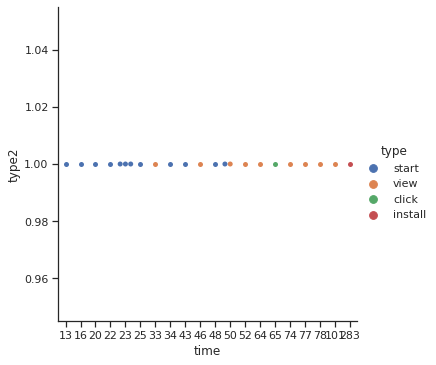

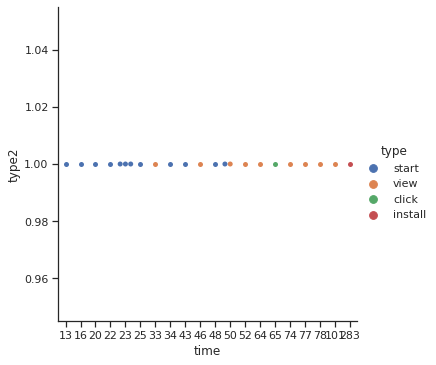

In [132]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)
seq = [['start', 13],   ['start', 16],   ['start', 20],   ['start', 22],   ['start', 23],   ['start', 23],   ['start', 23],   ['start', 25],   ['view', 33],   ['start', 34],   ['start', 43],   ['view', 46],   ['start', 48],   ['view', 50],   ['start', 50],   ['view', 52],   ['view', 64],   ['click', 65],   ['view', 74],   ['view', 77],   ['view', 78],   ['view', 101],   ['install', 283]]
seq
import pandas as pd
df = pd.DataFrame(seq, columns=['type', 'time'])
df['type2'] = 1
sns.catplot(x="time", y="type2", hue='type',kind="swarm", data=df);

In [140]:
g1_a = np.array([[1.0, 0.0], [2.0, 4.6914403064823205], [3.0, 18.58484366190314], [4.0, 16.76857975390185], [4.0, 18.15045384308095], [4.0, 24.337639064406375], [4.0, 15.2884089835195], [3.0, 29.17232835597599], [3.0, 28.347763551028056], [4.0, 12.686046340906778], [3.0, 23.206332202006603], [3.0, 15.296372609405857], [4.0, 16.610430141301453], [2.0, 19.186863807379424], [2.0, 33.31980537367933], [3.0, 8.498124109751478], [5.0, 0.0], [2.0, 3.331522561234678], [3.0, 22.10904791316873], [3.0, 17.080410040073208], [4.0, 14.371560876829621]])
g2_a = np.array([[1.0, 0.0], [2.0, 7.365160844495803], [2.0, 28.209554853468475], [4.0, 12.141093545336151], [3.0, 33.81658465813854], [3.0, 25.832594191835824], [2.0, 21.886705741521634], [4.0, 13.71954181836108], [3.0, 15.470284416096828], [4.0, 22.201133672926517], [3.0, 10.975467035170336], [5.0, 25.43840457061526], [4.0, 21.41890790231001], [4.0, 17.041606332468493], [3.0, 29.384789290336244], [2.0, 15.550985560540632], [2.0, 16.13254324925227], [4.0, 21.638743789514084], [4.0, 14.197550448628895], [4.0, 19.944172892625293], [4.0, 11.84191268371002]])

g1_a[:, 1] = np.cumsum(g1_a[:, 1])
g2_a[:, 1] = np.cumsum(g2_a[:, 1])

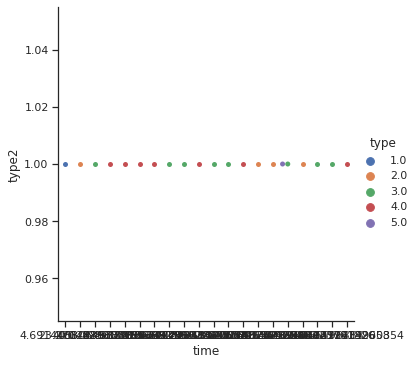

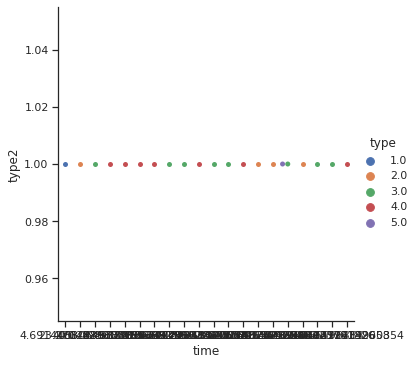

In [144]:
df = pd.DataFrame(g1_a, columns=['type', 'time'])
df['type2'] = 1
sns.catplot(x="time", y="type2", hue='type',kind="swarm", data=df);

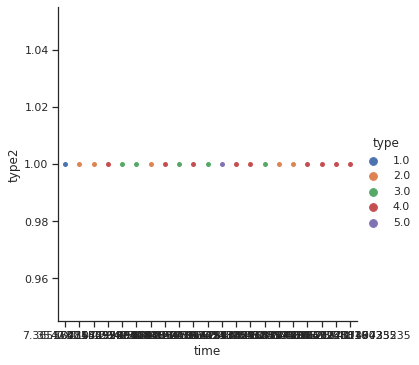

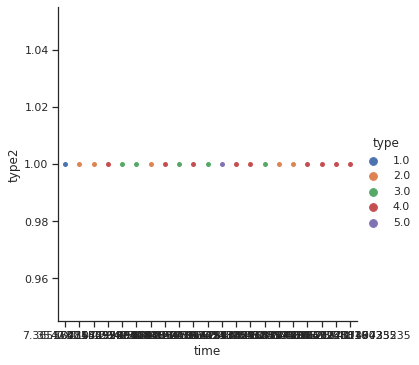

In [145]:
df = pd.DataFrame(g2_a, columns=['type', 'time'])
df['type2'] = 1
sns.catplot(x="time", y="type2", hue='type',kind="swarm", data=df);